<a href="https://colab.research.google.com/github/operixon/mlsg-kaggle/blob/master/mouseprobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [55]:
import pandas as pd
import glob
import os


# Zmienne globalne

In [56]:
columnNames = ["time","x","y"]

# Pobranie danych

In [57]:
%%bash
rm -rf mouseml
git clone https://github.com/operixon/mouseml.git


Cloning into 'mouseml'...


In [58]:
!ls mouseml/test1/local/clean

t1-artur-local-session-1.txt  t1-konrad-local-session-1-touhpad.txt
t1-artur-local-session-2.txt  t1-konrad-local-session-2-mouse.txt


In [68]:
def readFromFile(f):
  print(f)
  d = pd.read_csv(f, skiprows=3, header=None)
  d.columns = columnNames
  d['file'] = f
  return d

def readFromDir(dir,t) :
  localData = pd.concat(map(readFromFile, glob.glob(os.path.join(dir, "*.txt"))))
  localData['session'] = t
  return localData

def loadData() :
   return pd.concat([readFromDir('mouseml/test1/local/clean/','local'),
                    readFromDir('mouseml/test1/remote/clean/','remote')])

data = loadData()


mouseml/test1/local/clean/t1-artur-local-session-2.txt
mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt
mouseml/test1/local/clean/t1-artur-local-session-1.txt
mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt


# Ekstrakcja cech

In [60]:

def preproces(df):
  dfc = df.copy()
  diff = dfc.diff()
  dfc["dx"] = diff["x"].abs()
  dfc["dy"] = diff["y"].abs()
  return dfc

In [61]:
u1L = preproces(u1L)
u1R = preproces(u1R)



NameError: ignored

# Podstawowe statystyki

In [ ]:
u1L.describe()


,time,x,y,dx,dy
count,3126.000000,3126.000000,3126.000000,3125.00000,3125.000000
mean,115522.822137,726.666347,347.388036,17.51104,11.416960
std,93222.261887,245.093354,114.928592,45.15186,28.252541
min,1386.000000,273.000000,11.000000,0.00000,0.000000
25%,29308.750000,541.000000,274.000000,1.00000,1.000000
50%,93976.500000,670.500000,362.000000,4.00000,3.000000
75%,189632.000000,885.750000,428.000000,15.00000,10.000000
max,302402.000000,1571.000000,604.000000,681.00000,395.000000


In [ ]:
u1R.describe()

,time,x,y,dx,dy
count,2907.000000,2907.000000,2907.000000,2906.000000,2906.000000
mean,193145.240798,824.608875,335.031992,22.650034,12.264969
std,115717.387945,283.228231,111.094372,41.241637,19.149165
min,5982.000000,338.000000,32.000000,0.000000,0.000000
25%,89745.000000,612.000000,253.000000,2.000000,2.000000
50%,198841.000000,781.000000,341.000000,8.000000,6.000000
75%,293423.000000,1041.000000,418.000000,24.000000,14.000000
max,404968.000000,1609.000000,610.000000,682.000000,226.000000


# Wykresy

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f71c213bc50>,
      dtype=object)

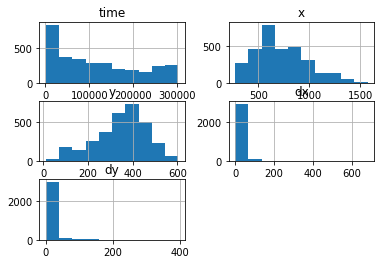

In [ ]:
u1L.hist()

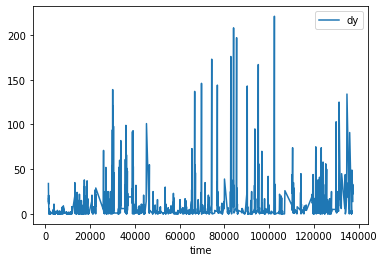

In [ ]:
u1L[:2000].plot(kind="line",x="time",y="dy")

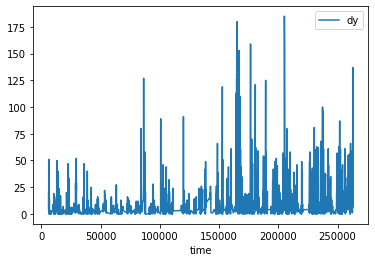

In [ ]:
u1R[:2000].plot(kind="line",x="time",y="dy")


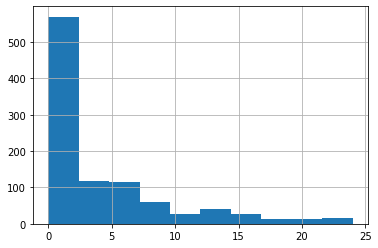

In [ ]:
u1L[(u1L.dy < u1L.dy.quantile(0.9))].dy[:1000].hist()

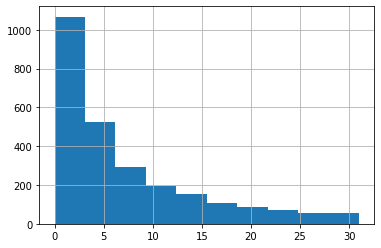

In [ ]:
u1R[(u1R.dy < u1R.dy.quantile(0.9))].dy[:1000].hist()

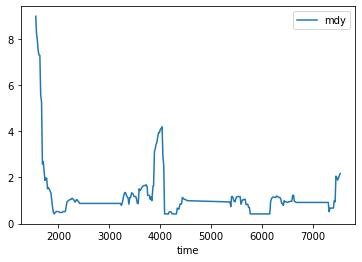

In [ ]:
u1L["mdy"] = u1L.rolling(10).mean().dy
u1L[:200].plot(x="time",y=["mdy"])

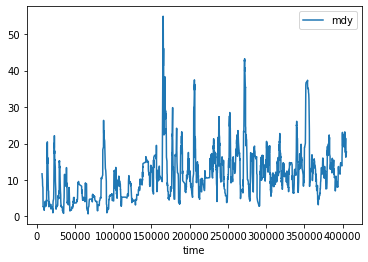

In [ ]:
u1R["mdy"] = u1R.rolling(20).mean().dy
u1R.plot(x="time",y="mdy")